# PI Control Example
also featuring computation delays and firing rate estimates

In [562]:
# if previously used Brian objects are preventing simulation
%reset -f
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [563]:
from brian2 import *
from clocsim.base import *

import matplotlib.pyplot as plt

## Create the Brian network

In [564]:
population = NeuronGroup(100, '''
            dv/dt = (-v - 70*mV + Rm*I) / tau : volt
            tau: second
            Rm: ohm
            I: amp''',
        threshold='v>-50*mV',
        reset='v=-70*mV'
)
population.tau = 10*ms
population.Rm = 100*Mohm
population.I = 0*mA
population.v = -70*mV

input_group = PoissonGroup(100, np.arange(100)*Hz + 10*Hz)

S = Synapses(input_group, population, on_pre='v+=5*mV')
S.connect(condition=f'abs(i-j)<={3}')
S2 = Synapses(population, population, on_pre='v+=2*mV')
S2.connect(condition=f'abs(i-j)<={1}')
# S2.connect(p=0.1)

pop_mon = SpikeMonitor(population)

### Run simulation without control:

In [565]:
net = Network(collect())
net.run(100*ms)

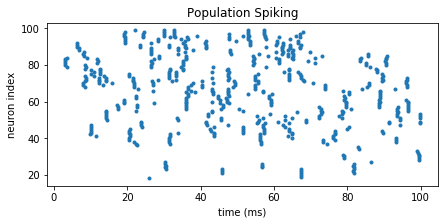

In [566]:
fig_size=(7, 3)
plt.figure(figsize=fig_size);
plt.plot(pop_mon.t / ms, pop_mon.i, '.'); 
plt.title('Population Spiking'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');

## Control loop setup
Now for the control loop--to control neuron $i$, we need to:
- capture spiking using a `SpikeRecorder`
- estimating its firing rate using a `FiringRateEstimator`
- compute the stimulus intensity with a `PIController`
- pass that to a `StateVariableSetter` stimulator manipulating input current

In [567]:
from clocsim.base import *
from clocsim.recorders import GroundTruthSpikeRecorder
from clocsim.stimulators import StateVariableSetter

i = 20  # neuron to control

sim = CLOCSimulator(net)
rec = GroundTruthSpikeRecorder('spike_rec', index=i)
sim.inject_recorder(rec, population)

Note that we can set delays for components in the control loop to better
approximate the experiment:

In [568]:
from clocsim.control_loop import DelayControlLoop
from clocsim.control_loop.observers import FiringRateEstimator
from clocsim.control_loop.delays import ConstantDelay
from clocsim.control_loop.controllers import PIController

# the target firing rate trajectory, as a function of time
def target_Hz(t_ms):
    t_s = t_ms / 1000
    a = 200
    return a + a*np.sin(2*np.pi*20*t_s)

class PIRateControlLoop(DelayControlLoop):
    def __init__(self):
        super().__init__()
        self.rate_estimator = FiringRateEstimator(10, 1,
                delay=ConstantDelay(1.1), save_history=True)

        self.pi_controller = PIController(target_Hz, Kp=0.005, Ki=0.001, 
                sample_period_ms=1, delay=ConstantDelay(0.87),
                save_history=False)

    def compute_ctrl_signal(self, state_dict, time_ms):
        spikes = state_dict['spike_rec']
        out, time_ms = self.rate_estimator.process_data(spikes, time_ms)
        out, time_ms = self.pi_controller.process_data(out, time_ms)
        # this dictionary output format allows for the flexibility
        # of controlling multiple stimulators
        out_dict = {'I_stim': out}  
        return out_dict, time_ms

ctrl_loop = PIRateControlLoop()
sim.set_control_loop(ctrl_loop)

In [569]:
sim.inject_stimulator(
        StateVariableSetter(
            'I_stim', index=i, variable_to_ctrl='I', unit=nA),
        population
)

## Run the simulation

In [570]:
sim.run(200*ms)

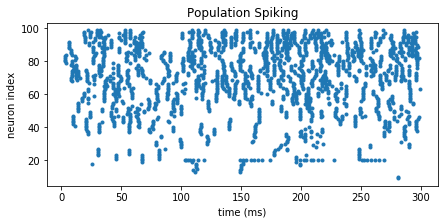

In [571]:
fig_size=(7, 3)
fig, ax = plt.subplots(figsize=fig_size);
ax.plot(pop_mon.t / ms, pop_mon.i, '.'); 
plt.title('Population Spiking'); plt.ylabel('neuron index'); plt.xlabel('time (ms)');
# ax2 = ax.secondary_yaxis('right')
ax.plot()
plt.show()


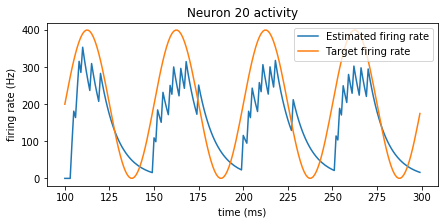

In [574]:
plt.figure(figsize=fig_size);
plt.plot(ctrl_loop.rate_estimator.t, ctrl_loop.rate_estimator.values);
plt.plot(ctrl_loop.rate_estimator.t, [target_Hz(t) for t in ctrl_loop.rate_estimator.t]);
plt.ylabel('firing rate (Hz)'); plt.xlabel('time (ms)');
plt.legend(['Estimated firing rate', 'Target firing rate']);
plt.title(f'Neuron {i} activity');